# **Step1: Setup & Import packages**
must have python 3.9 or 3.10 for tensorflow to work, higher versions are not supported

#### **Install the following packages:**

python3.9 -m pip install tensorflow==2.17.1

python3.9 -m pip install numpy 

python3.9 -m pip install scikit-learn

python3.9 -m pip install matplotlib

#### **Run the project with the following command in the terminal oppened at the file location:**

python3.9 imageclassifier.py

In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Activation, Dropout, Input
from tensorflow.keras.optimizers import Adam, Nadam, SGD, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix , classification_report
import matplotlib.pyplot as plt
import numpy as np
import random, os, json

print("---\nPackages imported!",
      "\ntensorflow version: ",tf.__version__, 
      "\nusing gpu: ", len(tf.config.list_physical_devices('GPU')) > 0, 
      "\n---")

---
Packages imported! 
tensorflow version:  2.17.1 
using gpu:  False 
---


# **Step2: Load & Display Data**

## Load data

In [6]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# One-hot encode the labels for training
y_train = to_categorical(y_train, 10)  # 10 classes in CIFAR-10
y_test = to_categorical(y_test, 10)
# Define the class names for CIFAR-10
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
# Normalize the images
x_train = x_train / 255.0
x_test = x_test / 255.0
print("---\n","Data loaded!","\n---")

---
 Data loaded! 
---


## Display data

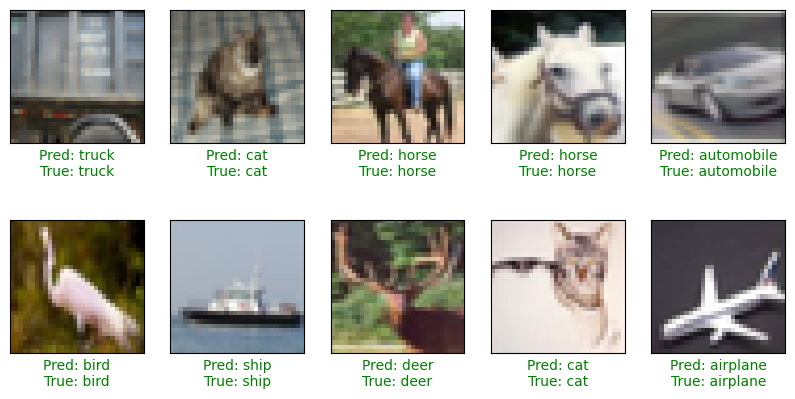

In [7]:
# Function to show random examples with true and predicted labels
def show_random_examples(x, y, p):
    indices = np.random.choice(len(x), size=10, replace=False)
    x = x[indices]
    y = y[indices]
    p = p[indices]
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(f"Pred: {classes[np.argmax(p[i])]}\nTrue: {classes[np.argmax(y[i])]}", color=col)
    plt.show()
show_random_examples(x_train, y_train, y_train)

# **Step3: Build Model**

## Apply Data Augmentation

In [9]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)
print("---\n","Data Augmentation Applied!","\n---")

---
 Data Augmentation Applied! 
---


## Create Models

In [5]:

# Define the model structures as functions
# Model 1
def model1(dropout_rate=0.3):
    model = models.Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(96, (3, 3), activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(10, activation='softmax')
    ])
    # Model Summary
    model.summary()
    return model

# Model 2
def model2(dropout_rate=0.3):
    model = models.Sequential([
        # Layer 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),
        # Layer 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate + 0.1),
        # Layer 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate + 0.2),
        # Layer 4
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate + 0.2),
        Dense(10, activation='softmax')
    ])
    # Model Summary
    model.summary()
    return model

## Train Models

In [6]:

# Function that Train one Model with specific parameters
def train_model(model, model_name="model", batch=128, epochs=10, patience=3, optimizer='adam', dropout_rate=0.3, learning_rate=0.002):
    model_ = model
    if optimizer == "Adam":
        optimizer_ = Adam(learning_rate=learning_rate)
    elif optimizer == "Nadam":
        optimizer_ = Nadam(learning_rate=learning_rate)
    elif optimizer == "RMSprop":
        optimizer_ = RMSprop(learning_rate=learning_rate)
    elif optimizer == "SGD":
        optimizer_ = SGD(learning_rate=learning_rate)
    else:
        optimizer_ = 'adam' # adam with no learning-rate if no value given
    # Compile the model
    model_.compile(
        optimizer=optimizer_,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print("---\n","Model Compiled!","\n---")
    # Callbacks
    early_stopping_ = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True
    )
    lr_scheduler_ = LearningRateScheduler(lambda epoch: learning_rate * (0.5 ** (epoch // 10)))
    checkpoint_path = f'{model_name}_{batch}b_{epochs}e_{optimizer}.keras'
    checkpoint_ = ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )
    # Train
    print("---\n", f"Trainning: {model_name}", 
          "\n", f"batch_size={batch}", 
          "\n", f"epochs={epochs}", 
          "\n", f"patience={patience}", 
          "\n", f"optimizer={optimizer}", 
          "\n", f"learning_rate={learning_rate}", 
          "\n", f"dropout_rate={dropout_rate}", "\n---")
    history_ = model_.fit(
        datagen.flow(x_train, y_train, batch_size=batch),
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=[lr_scheduler_, early_stopping_, checkpoint_],
        verbose=1
    )
    print("---\n","Model trained!","\n---")
    # Save model
    print("---\n", 
          f"Model saved at: {os.path.abspath(f'{model_name}_{batch}b_{epochs}e_{optimizer}.keras')}",
          "\n---")
    # Save the history
    with open(f'{model_name}_{batch}b_{epochs}e_{optimizer}.json', 'w') as f:
        json.dump(history_.history, f)
    print("---\n",
          f"History saved at: {os.path.abspath(f'{model_name}_{batch}b_{epochs}e_{optimizer}.json ')}",
          "\n---")
    # Return the trained model and its validation accuracy for comparison
    val_accuracy = max(history_.history['val_accuracy'])
    return model_, history_.history, val_accuracy

# **Step4: Find the best Hyper-parameters**

## Compare diffrent hyper-parameters

In [7]:
# Function to find and save the best model and its training history
def find_best_model():
    # model 1
    # 10 epochs
    train_model(model1(), model_name="model1", batch=128, epochs=10) # 68%
    train_model(model1(), model_name="model1", batch=200, epochs=10) # 69%
    # 20 epochs
    train_model(model1(), model_name="model1", batch=32, epochs=20) # 71%
    train_model(model1(), model_name="model1", batch=64, epochs=20) # 73%
    # model 2
    # 10 epochs
    train_model(model2(), model_name="model2", batch=128, epochs=10) # 79%
    train_model(model2(), model_name="model2", batch=200, epochs=10) # 70% (overfitting)
    # 20 epochs
    train_model(model2(), model_name="model2", batch=64, epochs=20) # 83% - best model
    train_model(model2(), model_name="model2", batch=128, epochs=20) # 81%
find_best_model()

C:\Users\niema\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 96)       │       110,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,362 (1.47 MB)

 Trainable params: 384,362 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

---
 Model Compiled! 
---
---
 Trainning: model1 
 batch_size=128 
 epochs=10 
 patience=3 
 optimizer=adam 
 learning_rate=0.002 
 dropout_rate=0.3 
---


C:\Users\niema\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.2639 - loss: 1.9426
Epoch 1: val_accuracy improved from -inf to 0.47140, saving model to model1_128b_10e_adam.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 127s 316ms/step - accuracy: 0.2641 - loss: 1.9421 - val_accuracy: 0.4714 - val_loss: 1.4577 - learning_rate: 0.0020
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.4700 - loss: 1.4585
Epoch 2: val_accuracy improved from 0.47140 to 0.53960, saving model to model1_128b_10e_adam.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 129s 329ms/step - accuracy: 0.4701 - loss: 1.4584 - val_accuracy: 0.5396 - val_loss: 1.2537 - learning_rate: 0.0020
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.5291 - loss: 1.3087
Epoch 3: val_accuracy improved from 0.53960 to 0.57860, saving model to model1_128b_10e_adam.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 121s 310ms/step - accuracy: 0.5292 - loss: 1.3086 - val_accuracy: 0.5786 - val_loss: 1.1845 - learning_rate: 0.0020
Epoch 4

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 96)       │       110,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,362 (1.47 MB)

 Trainable params: 384,362 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

---
 Model Compiled! 
---
---
 Trainning: model1 
 batch_size=200 
 epochs=10 
 patience=3 
 optimizer=adam 
 learning_rate=0.002 
 dropout_rate=0.3 
---
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.2678 - loss: 1.9492
Epoch 1: val_accuracy improved from -inf to 0.49490, saving model to model1_200b_10e_adam.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 113s 436ms/step - accuracy: 0.2681 - loss: 1.9484 - val_accuracy: 0.4949 - val_loss: 1.3721 - learning_rate: 0.0020
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.4656 - loss: 1.4652
Epoch 2: val_accuracy improved from 0.49490 to 0.51820, saving model to model1_200b_10e_adam.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 436ms/step - accuracy: 0.4657 - loss: 1.4650 - val_accuracy: 0.5182 - val_loss: 1.3471 - learning_rate: 0.0020
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.5234 - loss: 1.3309
Epoch 3: val_accuracy improved from 0.51820 to 0.57120, saving model to model1_200b_10e_adam.kera

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 96)       │       110,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,362 (1.47 MB)

 Trainable params: 384,362 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

---
 Model Compiled! 
---
---
 Trainning: model1 
 batch_size=32 
 epochs=20 
 patience=3 
 optimizer=adam 
 learning_rate=0.002 
 dropout_rate=0.3 
---
Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2751 - loss: 1.9264
Epoch 1: val_accuracy improved from -inf to 0.48310, saving model to model1_32b_20e_adam.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 139s 87ms/step - accuracy: 0.2751 - loss: 1.9263 - val_accuracy: 0.4831 - val_loss: 1.3932 - learning_rate: 0.0020
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4535 - loss: 1.4895
Epoch 2: val_accuracy improved from 0.48310 to 0.56270, saving model to model1_32b_20e_adam.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 133s 85ms/step - accuracy: 0.4535 - loss: 1.4895 - val_accuracy: 0.5627 - val_loss: 1.2215 - learning_rate: 0.0020
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5090 - loss: 1.3670
Epoch 3: val_accuracy improved from 0.56270 to 0.57010, saving model to model1_32b_20e_adam.ker

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 96)       │       110,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,362 (1.47 MB)

 Trainable params: 384,362 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

---
 Model Compiled! 
---
---
 Trainning: model1 
 batch_size=64 
 epochs=20 
 patience=3 
 optimizer=adam 
 learning_rate=0.002 
 dropout_rate=0.3 
---
Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.2846 - loss: 1.9131
Epoch 1: val_accuracy improved from -inf to 0.49080, saving model to model1_64b_20e_adam.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 126s 156ms/step - accuracy: 0.2847 - loss: 1.9128 - val_accuracy: 0.4908 - val_loss: 1.3629 - learning_rate: 0.0020
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.4850 - loss: 1.4210
Epoch 2: val_accuracy improved from 0.49080 to 0.58470, saving model to model1_64b_20e_adam.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 124s 159ms/step - accuracy: 0.4850 - loss: 1.4210 - val_accuracy: 0.5847 - val_loss: 1.1563 - learning_rate: 0.0020
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5488 - loss: 1.2796
Epoch 3: val_accuracy improved from 0.58470 to 0.62340, saving model to model1_64b_20e_adam.keras
78

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 552,874 (2.11 MB)

 Trainable params: 551,722 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

---
 Model Compiled! 
---
---
 Trainning: model2 
 batch_size=128 
 epochs=10 
 patience=3 
 optimizer=adam 
 learning_rate=0.002 
 dropout_rate=0.3 
---
Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.3082 - loss: 2.1335
Epoch 1: val_accuracy improved from -inf to 0.23210, saving model to model2_128b_10e_adam.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 244s 592ms/step - accuracy: 0.3084 - loss: 2.1325 - val_accuracy: 0.2321 - val_loss: 2.5651 - learning_rate: 0.0020
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.5227 - loss: 1.3167
Epoch 2: val_accuracy improved from 0.23210 to 0.57060, saving model to model2_128b_10e_adam.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 256s 577ms/step - accuracy: 0.5227 - loss: 1.3166 - val_accuracy: 0.5706 - val_loss: 1.3389 - learning_rate: 0.0020
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.6020 - loss: 1.1085
Epoch 3: val_accuracy improved from 0.57060 to 0.64810, saving model to model2_128b_10e_adam.kera

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 552,874 (2.11 MB)

 Trainable params: 551,722 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

---
 Model Compiled! 
---
---
 Trainning: model2 
 batch_size=200 
 epochs=10 
 patience=3 
 optimizer=adam 
 learning_rate=0.002 
 dropout_rate=0.3 
---
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.3092 - loss: 2.1434
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to model2_200b_10e_adam.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 223s 854ms/step - accuracy: 0.3095 - loss: 2.1419 - val_accuracy: 0.1000 - val_loss: 4.8935 - learning_rate: 0.0020
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - accuracy: 0.5177 - loss: 1.3236
Epoch 2: val_accuracy improved from 0.10000 to 0.57760, saving model to model2_200b_10e_adam.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 218s 870ms/step - accuracy: 0.5178 - loss: 1.3234 - val_accuracy: 0.5776 - val_loss: 1.1860 - learning_rate: 0.0020
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.5914 - loss: 1.1429
Epoch 3: val_accuracy improved from 0.57760 to 0.61240, saving model to model2_200b_10e_adam.kera

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 552,874 (2.11 MB)

 Trainable params: 551,722 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

---
 Model Compiled! 
---
---
 Trainning: model2 
 batch_size=64 
 epochs=20 
 patience=3 
 optimizer=adam 
 learning_rate=0.002 
 dropout_rate=0.3 
---
Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.3290 - loss: 2.0450
Epoch 1: val_accuracy improved from -inf to 0.50540, saving model to model2_64b_20e_adam.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 253s 308ms/step - accuracy: 0.3291 - loss: 2.0445 - val_accuracy: 0.5054 - val_loss: 1.4499 - learning_rate: 0.0020
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.5447 - loss: 1.2671
Epoch 2: val_accuracy improved from 0.50540 to 0.57230, saving model to model2_64b_20e_adam.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 241s 308ms/step - accuracy: 0.5447 - loss: 1.2671 - val_accuracy: 0.5723 - val_loss: 1.2943 - learning_rate: 0.0020
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.6197 - loss: 1.0726
Epoch 3: val_accuracy improved from 0.57230 to 0.65930, saving model to model2_64b_20e_adam.keras
78

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 552,874 (2.11 MB)

 Trainable params: 551,722 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

---
 Model Compiled! 
---
---
 Trainning: model2 
 batch_size=128 
 epochs=20 
 patience=3 
 optimizer=adam 
 learning_rate=0.002 
 dropout_rate=0.3 
---
Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.3128 - loss: 2.1142
Epoch 1: val_accuracy improved from -inf to 0.26840, saving model to model2_128b_20e_adam.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 238s 577ms/step - accuracy: 0.3131 - loss: 2.1132 - val_accuracy: 0.2684 - val_loss: 2.2126 - learning_rate: 0.0020
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.5234 - loss: 1.3288
Epoch 2: val_accuracy improved from 0.26840 to 0.51580, saving model to model2_128b_20e_adam.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 226s 579ms/step - accuracy: 0.5234 - loss: 1.3287 - val_accuracy: 0.5158 - val_loss: 1.5250 - learning_rate: 0.0020
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.5932 - loss: 1.1476
Epoch 3: val_accuracy improved from 0.51580 to 0.61870, saving model to model2_128b_20e_adam.kera

## Diplay plot Comparaison

---
 All histories loaded successfully! 
---


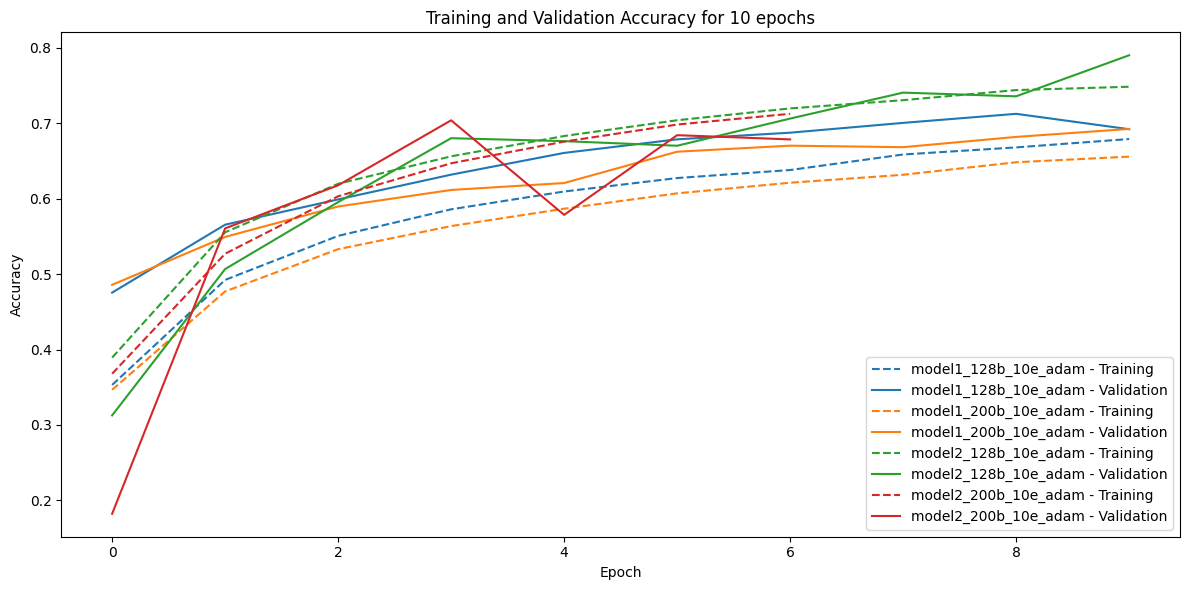

---
 All histories loaded successfully! 
---


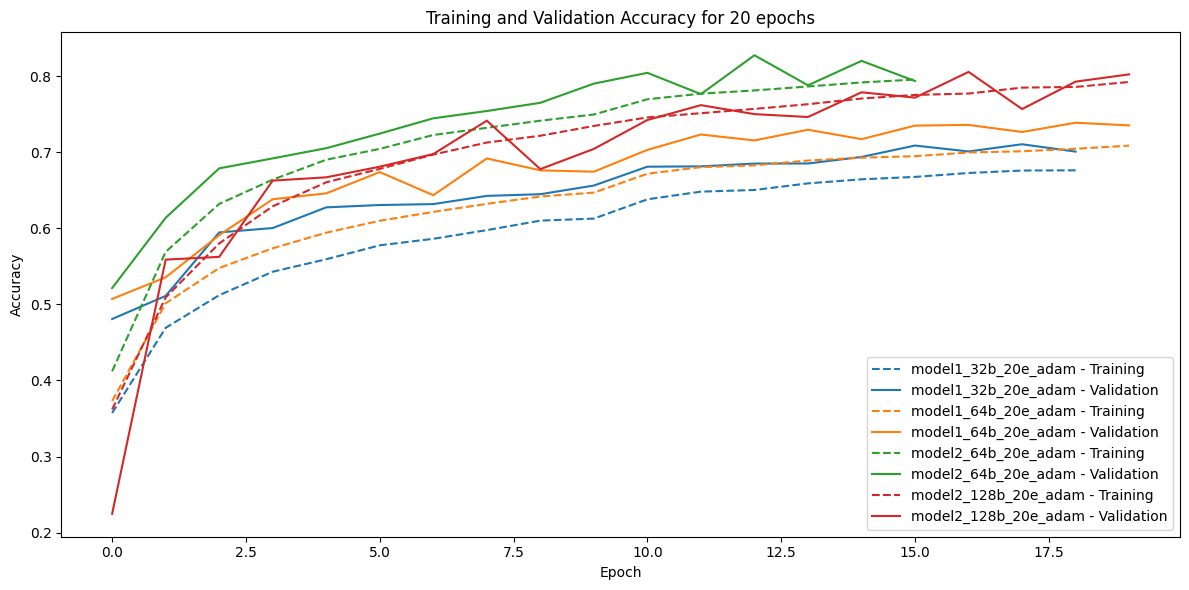

In [16]:
# Function to compare different models
def compare_data():
    models10_names = [
        "model1_128b_10e_adam",
        "model1_200b_10e_adam",
        "model2_128b_10e_adam",
        "model2_200b_10e_adam"
    ]
    histories_ = []
    for name in models10_names:
        with open(f'models/{name}.json', 'r') as f:
            histories_.append(json.load(f))
    print("---\n","All histories loaded successfully!","\n---")
    colors = plt.cm.tab10(range(len(models10_names)))
    plt.figure(figsize=(12, 6))
    # Plot training and validation accuracy
    plt.subplot(1, 1, 1)
    for history, name, color in zip(histories_, models10_names, colors):
        plt.plot(history['accuracy'], linestyle='--', color=color, label=f'{name} - Training')
        plt.plot(history['val_accuracy'], linestyle='-', color=color, label=f'{name} - Validation')
    plt.title('Training and Validation Accuracy for 10 epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
    models20_names = [
        "model1_32b_20e_adam",
        "model1_64b_20e_adam",
        "model2_64b_20e_adam",
        "model2_128b_20e_adam"
    ]
    # Load all histories
    histories_ = []
    for name in models20_names:
        with open(f'models/{name}.json', 'r') as f:
            histories_.append(json.load(f))
    print("---\n","All histories loaded successfully!","\n---")
    colors = plt.cm.tab10(range(len(models20_names)))
    plt.figure(figsize=(12, 6))
    # Plot training and validation accuracy
    plt.subplot(1, 1, 1)
    for history, name, color in zip(histories_, models20_names, colors):
        plt.plot(history['accuracy'], linestyle='--', color=color, label=f'{name} - Training')
        plt.plot(history['val_accuracy'], linestyle='-', color=color, label=f'{name} - Validation')
    plt.title('Training and Validation Accuracy for 20 epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

compare_data()

## Select best Model & hyper-parameters

In [ ]:
train_model(model2(), model_name="model2", batch=64, epochs=20, optimizer='Adam', learning_rate=0.010) # 83% - best model

In [3]:
# best model & hyper parameters:
best_model = "model2_64b_20e_adam"
print("---\n",
      "Best Model Saved!",
      "\nData Augmentation",
      "\nmodel 2",
      "\nepochs 20",
      "\nbatch 64",
      "\npatience 3",
      "\noptimizer adam",
      "\ndrop out rate 0.3",
      "\nlearning rate 0.010",
      "\n=> accuracy rate 83%",
      "\n---")


---
 Best Model Saved! 
Data Augmentation 
model 2 
epochs 20 
batch 64 
patience 3 
optimizer adam 
drop out rate 0.3 
learning rate 0.010 
=> accuracy rate 83% 
---


# **Step5: Display The best model Results**

---
 Model loaded successfully! 
---
---
 History loaded successfully! 
---
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step
---
 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.84      1000
           1       0.88      0.95      0.91      1000
           2       0.79      0.74      0.76      1000
           3       0.79      0.62      0.69      1000
           4       0.84      0.77      0.81      1000
           5       0.84      0.71      0.77      1000
           6       0.72      0.94      0.81      1000
           7       0.89      0.86      0.88      1000
           8       0.91      0.91      0.91      1000
           9       0.82      0.93      0.87      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000
 
---


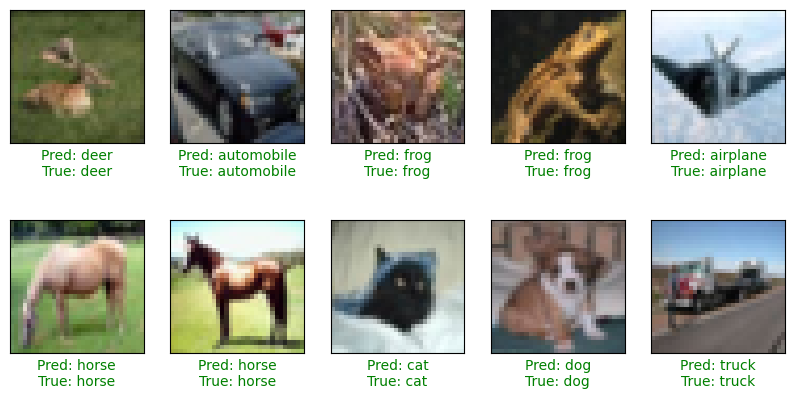

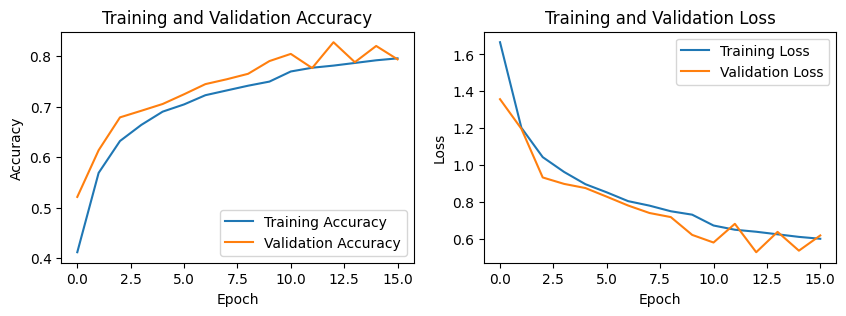

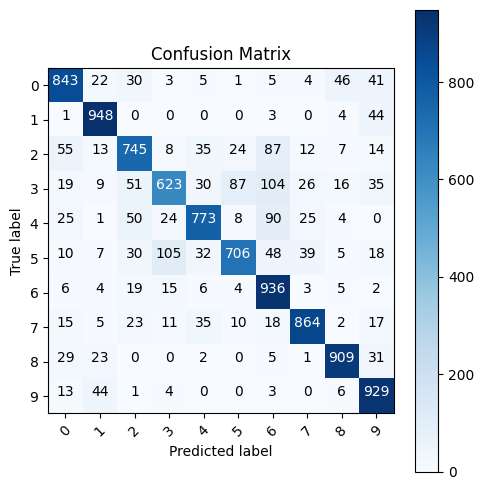

In [18]:
# function that display relevent statistics
def display_data(model_name="model"):
    ## Load Data
    model = load_model(f'models/{model_name}.keras')
    print("---\n","Model loaded successfully!","\n---")
    # Load the history from the saved JSON file
    with open(f'models/{model_name}.json', 'r') as f:
        history_data = json.load(f)
    print("---\n","History loaded successfully!","\n---")
    ## Get data
    # Get the predictions (probabilities)
    y_pred = model.predict(x_test)
    # Convert the predicted probabilities to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)
    # Convert the true labels from one-hot encoding to class labels
    y_test_classes = np.argmax(y_test, axis=1)
    ## Display Data
    # Show Classification Report
    print("---\n",
          "Classification Report:\n", 
          classification_report(y_test_classes, y_pred_classes),
          "\n---")
    # Show predicted labels
    show_random_examples(x_test, y_test, y_pred)
    # Plot for training and validation accuracy
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(history_data['accuracy'], label='Training Accuracy')
    plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    # Plot for training and validation loss as well
    plt.subplot(1, 2, 2)
    plt.plot(history_data['loss'], label='Training Loss')
    plt.plot(history_data['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # Show Plots
    plt.show()
    # Compute confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    # Plot the confusion matrix
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.colorbar()
    # Add labels for axes
    classes = [str(i) for i in range(10)]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    # Add values to cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > cm.max() / 2 else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    # Show confusion matrix
    plt.show()
display_data(model_name=best_model)